In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.datasets import load_boston
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV
import joblib
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score as AUC

## 加载数据

In [2]:
boston = load_boston()

In [3]:
X = boston.data
Y = boston.target

In [4]:
df = pd.DataFrame(X, columns=boston.feature_names)

In [5]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [7]:
# 划分数据集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y
                                                    , test_size = 0.2
                                                    , random_state=20
                                                   )

## 建模

### 原生接口

In [8]:
# 转换指定数据类型
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test)

In [9]:
# 指定参数

params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",  # 回归任务
    "metric": {"l2", "auc", "mse"},
    "num_leaves": 31,  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    "learning_rate": 0.2,
    "feature_fraction": 0.9,  # 建树的特征选择比例
    "bagging_fraction": 0.8,  # 建树的采样比例
    "bagging_freq": 5,  # K意味着每k次迭代执行bagging
    "verbose": 1,
    
}

In [10]:
# training model
gbm =lgb.train(params=params, train_set=lgb_train
          , num_boost_round=200
          , valid_sets=lgb_eval
          , early_stopping_rounds=10
         )

[1]	valid_0's l2: 48.1141	valid_0's auc: 1
Training until validation scores don't improve for 10 rounds
[2]	valid_0's l2: 36.9433	valid_0's auc: 1
[3]	valid_0's l2: 29.7797	valid_0's auc: 1
[4]	valid_0's l2: 24.3468	valid_0's auc: 1
[5]	valid_0's l2: 21.4545	valid_0's auc: 1
[6]	valid_0's l2: 19.8794	valid_0's auc: 1
[7]	valid_0's l2: 18.8305	valid_0's auc: 1
[8]	valid_0's l2: 17.4252	valid_0's auc: 1
[9]	valid_0's l2: 16.8314	valid_0's auc: 1
[10]	valid_0's l2: 16.081	valid_0's auc: 1
[11]	valid_0's l2: 15.9075	valid_0's auc: 1
Early stopping, best iteration is:
[1]	valid_0's l2: 48.1141	valid_0's auc: 1


In [11]:
# 保存模型
joblib.dump(gbm, "./data/lgb.pkl")

['./data/lgb.pkl']

In [12]:
gbm.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('l2', 48.11408456374963),
                          ('auc', 1.0)])})

In [13]:
# 评估指标
MSE(Y_test, gbm.predict(data=X_test))

48.11408377454491

### sklearn接口

In [14]:
gbm = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.05)
gbm.fit(X_train, Y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.05, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [15]:
# 评估指标
MSE(Y_test, gbm.predict(X_test))

11.827460665407331

In [16]:
# 特征重要性
feature_import = pd.DataFrame(gbm.feature_importances_
                              , index=df.columns
                              , columns=["score"]
                             )
feature_import.sort_values(by="score", ascending=False)

,score
RM,258
LSTAT,257
DIS,188
NOX,158
AGE,141
CRIM,124
B,101
PTRATIO,100
TAX,85
INDUS,49


In [17]:
# 网格搜索
estimator = lgb.LGBMRegressor(num_leaves=31)
param_grid = {
    "learning": [0.1, 0.001, 1],
    "n_estimators": [20, 40]
}

In [32]:
gbm = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
gbm = gbm.fit(X_train, Y_train)

In [30]:
gbm.best_params_

{'learning': 0.1, 'n_estimators': 40}

In [31]:
gbm.cv_results_["mean_test_score"]

array([0.80872144, 0.84981015, 0.80872144, 0.84981015, 0.80872144,
       0.84981015])

In [34]:
gbm.best_score_

0.8407504431796051

### CV交差验证调参
0. 确定任务类型(回归、分类、排序等)，以及基学习器的类型(dark, gbdt、RF)  
1. 首先选择较高的学习率，大概0.1附近，这样是为了加快收敛的速度。这对于调参是很有必要的。
2. 对决策树基本参数调参
3. 正则化参数调参
4. 最后降低学习率，这里是为了最后提高准确率


#### 加载数据

In [40]:
cancer = load_breast_cancer()
X = cancer.data
Y = cancer.target

# 划分数据集
X_train, X_val, Y_train, Y_val = train_test_split(X, Y
                                                    , test_size = 0.2
                                                    , random_state=20
                                                   )

In [42]:
# 数据类型转换
data_train = lgb.Dataset(X_train, Y_train)
data_val = lgb.Dataset(X_val, Y_val)

#### 初始化状态(未调参)

In [29]:
# 参数设定为默认状态

params1 = {
      "boosting_type": "gbdt"
    , "objective": "binary" # 二分类任务
    , "metric": {"binary_logloss","auc"}
    , "device": "gpu"
    
    , "nthread": 4
    , "verbose": 1

    , "learning_rate": 0.1
    
    , "max_depth": 5
    , "num_leaves": 31  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    , "subsample": 1.0  # 数据采样
    , "colsample_bytree": 1.0  # 特征采样
    
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
}

In [30]:
cv_result1 = lgb.cv(params=params1, train_set=data_train
       , nfold=5
       , stratified=True
       , shuffle=True
#        , metrics="auc"
       , seed=0
      )

#### 此时可参数的状态

In [31]:
num_boost_round = 1000
params2 = {
      "boosting_type": "gbdt"
    , "objective": "binary" # 二分类任务
    , "metric": {"binary_logloss","auc"}
    
    , "nthread": 4
    , "verbose": 1

    , "learning_rate": 0.1
    
    , "max_depth": 5
    , "num_leaves": 31  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    , "subsample": 1.0  # 数据采样
    , "colsample_bytree": 1.0  # 特征采样
    
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
}

In [32]:
cv_result2 = lgb.cv(params=params2, train_set=data_train
#        , num_boost_round=num_boost_round
       , nfold=5
       , stratified=True
       , shuffle=True
#        , metrics="auc"
#        , early_stopping_rounds=50
       , seed=0
      )

In [33]:
#  选择最佳的estimators
print("Best_n_estimators: %d\nBest_cv_score: %.2f" 
      % (np.array(list(cv_result2.values())).shape[1],
         max(np.array(list(cv_result2.values()))[0])*100)
     )  

Best_n_estimators: 100
Best_cv_score: 58.36


#### 调整好的参数状态

In [34]:
params3 = {
      "boosting_type": "gbdt"
    , "objective": "binary" # 二分类任务
    , "metric": {"binary_logloss","auc"}
    
    , "nthread": 4
    , "verbose": 1

    , "learning_rate": 0.1
    
    , "max_depth": 5
    , "num_leaves": 31  # 由于lightGBM是leaves_wise生长，官方说法是要小于2^max_depth
    , "subsample": 1  # 数据采样
    , "colsample_bytree": 1  # 特征采样
    
    , 'reg_alpha': 0.0  # L1
    , 'reg_lambda': 0.0  # L2
}

In [35]:
cv_result3 = lgb.cv(params=params3, train_set=data_train
#        , num_boost_round=1000
       , nfold=5
       , stratified=True
       , shuffle=True
#        , metrics="auc"
#        , early_stopping_rounds=50
       , seed=0
      )

In [36]:
cv_result3.keys()

dict_keys(['binary_logloss-mean', 'binary_logloss-stdv', 'auc-mean', 'auc-stdv'])

#### 可视化调参数过程

#### AUC评估

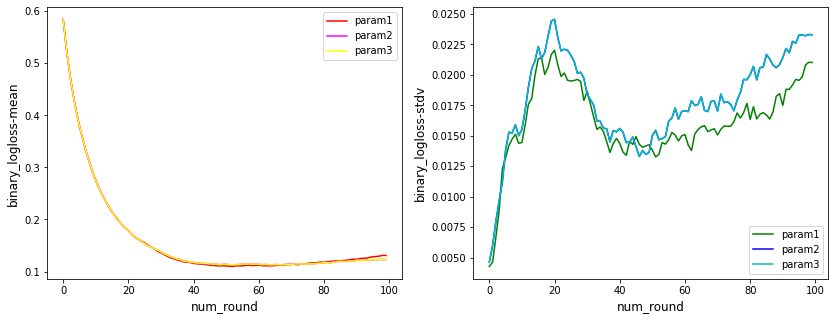

In [37]:
fig, ax = plt.subplots(1, 2, figsize = (14,5))

length1 = np.array(list(cv_result1.values())).shape[1]
length2 = np.array(list(cv_result2.values())).shape[1]
length3 = np.array(list(cv_result3.values())).shape[1]

ax[0].plot(range(length1), cv_result1[list(cv_result1.keys())[0]], label="param1", c="red")
ax[1].plot(range(length1), cv_result1[list(cv_result1.keys())[1]], label="param1", c="green")

ax[0].plot(range(length2), cv_result2[list(cv_result2.keys())[0]], label="param2", c="magenta")
ax[1].plot(range(length2), cv_result2[list(cv_result2.keys())[1]], label="param2", c="blue")

ax[0].plot(range(length3), cv_result3[list(cv_result3.keys())[0]], label="param3", c="yellow")
ax[1].plot(range(length3), cv_result3[list(cv_result3.keys())[1]], label="param3", c="c")

ax[0].set_xlabel("num_round", fontsize=12)
ax[1].set_xlabel("num_round", fontsize=12)
ax[0].set_ylabel(list(cv_result1.keys())[0], fontsize=12)
ax[1].set_ylabel(list(cv_result1.keys())[1], fontsize=12)
ax[0].legend()
ax[1].legend()
plt.show()

#### logloss评估

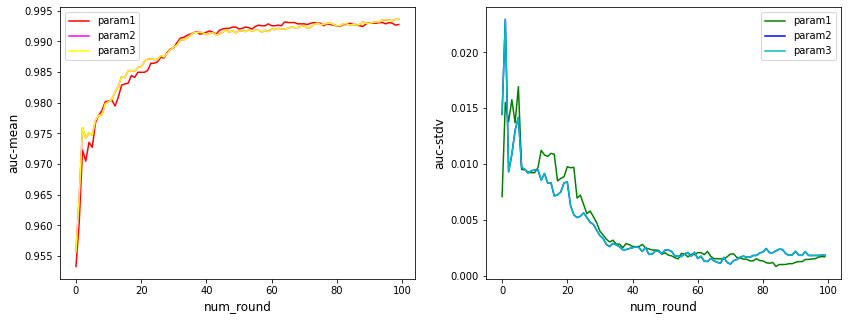

In [38]:
fig, ax = plt.subplots(1, 2, figsize = (14,5))

length1 = np.array(list(cv_result1.values())).shape[1]
length2 = np.array(list(cv_result2.values())).shape[1]
length3 = np.array(list(cv_result3.values())).shape[1]

ax[0].plot(range(length1), cv_result1[list(cv_result1.keys())[2]], label="param1", c="red")
ax[1].plot(range(length1), cv_result1[list(cv_result1.keys())[3]], label="param1", c="green")

ax[0].plot(range(length2), cv_result2[list(cv_result2.keys())[2]], label="param2", c="magenta")
ax[1].plot(range(length2), cv_result2[list(cv_result2.keys())[3]], label="param2", c="blue")

ax[0].plot(range(length3), cv_result3[list(cv_result3.keys())[2]], label="param3", c="yellow")
ax[1].plot(range(length3), cv_result3[list(cv_result3.keys())[3]], label="param3", c="c")

ax[0].set_xlabel("num_round", fontsize=12)
ax[1].set_xlabel("num_round", fontsize=12)
ax[0].set_ylabel(list(cv_result1.keys())[2], fontsize=12)
ax[1].set_ylabel(list(cv_result1.keys())[3], fontsize=12)
ax[0].legend()
ax[1].legend()
plt.show()

In [79]:
"""
当使用验证集，并加入早停机制时，可以设置在多少步之内，若评估指标不在下降
，则提前终止训练模型，多个评估指标使用时，每一个评估指标都可作为终止的条件
"""
lgb = lgb.train(params=params1, train_set=data_train, valid_sets=data_val
          , early_stopping_rounds=10
          , valid_names="valid"
         )

[1]	valid's binary_logloss: 0.609003	valid's auc: 0.983586
Training until validation scores don't improve for 10 rounds
[2]	valid's binary_logloss: 0.539881	valid's auc: 0.997633
[3]	valid's binary_logloss: 0.487594	valid's auc: 0.999842
[4]	valid's binary_logloss: 0.442517	valid's auc: 0.998422
[5]	valid's binary_logloss: 0.405518	valid's auc: 0.998422
[6]	valid's binary_logloss: 0.369729	valid's auc: 0.998737
[7]	valid's binary_logloss: 0.339327	valid's auc: 0.998737
[8]	valid's binary_logloss: 0.31426	valid's auc: 0.998422
[9]	valid's binary_logloss: 0.292678	valid's auc: 0.998737
[10]	valid's binary_logloss: 0.266928	valid's auc: 0.999369
[11]	valid's binary_logloss: 0.246412	valid's auc: 0.999684
[12]	valid's binary_logloss: 0.227861	valid's auc: 1
[13]	valid's binary_logloss: 0.214833	valid's auc: 1
[14]	valid's binary_logloss: 0.198117	valid's auc: 1
[15]	valid's binary_logloss: 0.184535	valid's auc: 1
[16]	valid's binary_logloss: 0.171254	valid's auc: 1
[17]	valid's binary_logl

In [80]:
#  模型保存
joblib.dump(lgb, filename="./data/lgb_module.pkl")

['./data/lgb_module.pkl']

In [81]:
#  模型加载
lgb = joblib.load("data/lgb_module.pkl")

In [82]:
#  预测结果为概率
lgb.predict(X_val, num_iteration=lgb.best_iteration)

array([0.89065439, 0.48977331, 0.183114  , 0.84665738, 0.18537753,
       0.183114  , 0.183114  , 0.82763568, 0.86867132, 0.22566688,
       0.18031577, 0.89389602, 0.81309763, 0.22566688, 0.8644268 ,
       0.68565499, 0.89389602, 0.47531337, 0.18156463, 0.81381438,
       0.86892885, 0.8843173 , 0.32188897, 0.1805256 , 0.18268158,
       0.33144292, 0.4444452 , 0.81528989, 0.75240454, 0.8944043 ,
       0.61689706, 0.84665738, 0.1774436 , 0.89389603, 0.2460287 ,
       0.18280764, 0.18125176, 0.82574631, 0.18059285, 0.8947028 ,
       0.19221329, 0.82057661, 0.89389602, 0.88890545, 0.18262628,
       0.7336193 , 0.77718499, 0.89375414, 0.81587021, 0.17414949,
       0.87766732, 0.87191963, 0.22440103, 0.89529127, 0.76318087,
       0.8947977 , 0.89389603, 0.89061232, 0.81361631, 0.87190176,
       0.89389602, 0.88072194, 0.89389602, 0.89389603, 0.45189957,
       0.89389602, 0.1935657 , 0.89226648, 0.87825251, 0.16114411,
       0.33006188, 0.25558619, 0.18884694, 0.84140786, 0.88810

In [83]:
probs = lgb.predict(X_val, num_iteration=lgb.best_iteration) 
FPR, recall, thresholds = roc_curve(Y_val, probs, pos_label=1)
area = AUC(Y_val, probs)

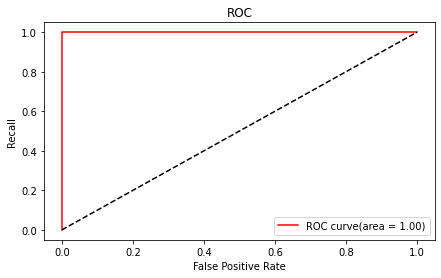

In [84]:
plt.figure(figsize=(7, 4))
plt.plot(FPR, recall, color="red",
         label = "ROC curve(area = %0.2f)" % area)
plt.plot([0, 1], [0, 1], c="black", linestyle = "--")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('Recall')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

## 参考
[LightGBM参数调优代码详解](https://blog.csdn.net/dzysunshine/article/details/92124011)  
[LightGBM调参笔记](https://blog.csdn.net/u012735708/article/details/83749703)  
[最简便的lightGBM GPU支持的安装、验证方法](https://blog.csdn.net/lccever/article/details/80535058#commentBox)

# 